In [1]:
import os
import cv2
import tensorflow
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

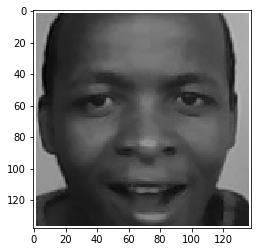

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

base_dir = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/train'

CATEGORIES = ["albertndege", "francisngethe",  "johnnzuki", "moseskinyua", "ronaldsamuel", "ashleywangare",  "harrysuter", "keithmartin", "patrickwainaina", "tracywanjiku", "elviswahome", "joebrian", "kennedythiga","markadalla", "geraldcastrol", "jameso", "rodneyosodo", "pricechiuri", "emmanuel", "johnnjoroge", "lynnsaidi", "richardwamalwa"]

for category in CATEGORIES:
    path = os.path.join(base_dir, category) #with the iterator named cartegory we are able to loop over files of diffrent people.
    for img in os.listdir(path):  # gets the images of diffrent people store in diffrent folders
        img_array = cv2.imread(os.path.join(path,img))  # convert to array cv.CV_BGR2GRAY
        #plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY))  # shows the image in a scale ##, cmap='gray'
        plt.imshow(img_array)
        plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!

In [4]:
print(img_array.shape)

(138, 138, 3)


#### Resizing the images

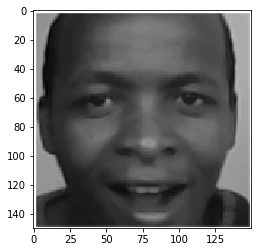

In [5]:
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
#plt.imshow(cv2.cvtColor(new_array, cv2.COLOR_BGR2GRAY)) ## COLOR_BGR2RGB ## cmap='gray'
plt.imshow(new_array)
plt.show()

In [6]:
print(new_array.shape)

(150, 150, 3)


### Creating training data

In [7]:
training_data = []  

def create_training_data():
    for category in CATEGORIES: 

        path = os.path.join(base_dir, category)  # create path to diffrent folders of diffrent people that we want to use for the training set
        class_num = CATEGORIES.index(category)  # get an index for each cartegory
        for img in tqdm(os.listdir(path)):  # iterate over each images of diffrent people in diffrent folders
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array   #,cv2.IMREAD_GRAYSCALE
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

100%|██████████| 224/224 [00:00<00:00, 1616.17it/s]

5057


In [8]:
import random
random.shuffle(training_data)

In [10]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

In [11]:
X.shape

(5057, 150, 150, 3)

In [12]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [13]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

## TRANSFER LEARNING

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16

#img_height = img_width = 100 
#channels = 3


#datagen = ImageDataGenerator(rescale=1.0/255)
model = VGG16(weights='imagenet', include_top = False, input_shape = (150, 150, 3))           

In [15]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
import keras

Using TensorFlow backend.


In [17]:
new_model = tensorflow.keras.Sequential()
for l in model.layers:
    model.trainable = False
    new_model.add(l)

In [18]:
new_model.add(Flatten())
new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(22, activation='softmax'))

In [106]:
new_model.summary()   

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       2

#### Image data generator to perform data augmentation

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

## Creating training data

In [21]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 5057 images belonging to 22 classes.


In [22]:
for data_batch, labels_batch in train_generator:

    print('data batch shape:', data_batch.shape)

    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32, 22)


## creating validation data

In [23]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_dir = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/validation'

In [24]:
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=(150, 150),
batch_size=32,
class_mode='categorical')

Found 395 images belonging to 22 classes.


In [25]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)

new_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Training the model

In [26]:
history = new_model.fit_generator(
        train_generator,
        steps_per_epoch=25,
        epochs=30, 
        validation_data = validation_generator,
        validation_steps=50)

Epoch 1/30
25/25 [==============================] - 573s 23s/step - loss: 3.4706 - accuracy: 0.1787 - val_loss: 2.0446 - val_accuracy: 0.5595
Epoch 2/30
25/25 [==============================] - 556s 22s/step - loss: 2.0692 - accuracy: 0.4109 - val_loss: 1.5313 - val_accuracy: 0.4925
Epoch 3/30
25/25 [==============================] - 574s 23s/step - loss: 1.4158 - accuracy: 0.5825 - val_loss: 0.9454 - val_accuracy: 0.7391
Epoch 4/30
25/25 [==============================] - 574s 23s/step - loss: 1.0848 - accuracy: 0.6825 - val_loss: 0.6661 - val_accuracy: 0.8289
Epoch 5/30
25/25 [==============================] - 572s 23s/step - loss: 0.8417 - accuracy: 0.7613 - val_loss: 0.6611 - val_accuracy: 0.8406
Epoch 6/30
25/25 [==============================] - 600s 24s/step - loss: 0.7033 - accuracy: 0.8150 - val_loss: 0.3978 - val_accuracy: 0.8627
Epoch 7/30
25/25 [==============================] - 579s 23s/step - loss: 0.6177 - accuracy: 0.8363 - val_loss: 0.5340 - val_accuracy: 0.8406
Epoch 

## Saving the model

In [27]:
 new_model.save_weights('4.2 facialrecognition model')

In [29]:
#file = h5.h5f.open('this4.2_facialrecognition_model.h5')

In [30]:
model_json = new_model.to_json()
with open("new_model.json", "w") as json_file:
    json_file.write(model_json)

In [31]:
save_path = "/home/tech-iguana//Documents/facial_stuff/tf_facial_model"

new_model.save_weights(os.path.join(save_path,"my_4.2_model_weights.json"))

# save neural network structure to JSON (no weights)
model_json = new_model.to_json()
with open(os.path.join(save_path,"my_4.2_model_weights.json"), "w") as json_file:
    json_file.write(model_json)

In [32]:
json_file = open('new_model.json', 'r')
loaded_model_json = json_file.read()

In [33]:
new_model.save(os.path.join(save_path,"themodell.h5"))

In [34]:
new_model.load_weights('themodell.h5')

In [36]:
#file = h5.h5f.open('themodell.h5')

In [37]:
loaded_model = tf.keras.models.load_model("themodell.h5")

## Plotting the results

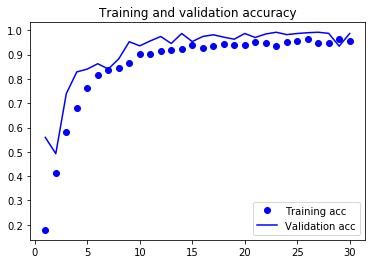

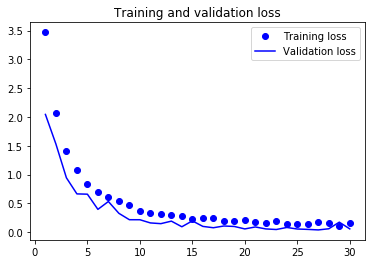

In [38]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Accuracy of the model

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir =  '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='categorical')
test_loss, test_acc = new_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 198 images belonging to 22 classes.
test acc: 0.97979796


### Creating / preparing test data

In [40]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import os

base_directory = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/test'

CATEGORIES = ["albertndege", "francisngethe",  "johnnzuki", "moseskinyua", "ronaldsamuel", "ashleywangare",  "harrysuter", "keithmartin", "patrickwainaina", "tracywanjiku", "elviswahome", "joebrian", "kennedythiga","markadalla", "geraldcastrol", "jameso", "rodneyosodo", "pricechiuri", "emmanuel", "johnnjoroge", "lynnsaidi", "richardwamalwa"]
IMG_SIZE = 150

test_data = []  

def create_test_data():
    for category in CATEGORIES: 

        path = os.path.join(base_directory, category)  # create path to diffrent folders of diffrent people that we want to use for the training set
        class_nums = CATEGORIES.index(category)  # get an index for each cartegory
        for img in tqdm(os.listdir(path)):  # iterate over each images of diffrent people in diffrent folders
            try:
                img_in_array = cv2.imread(os.path.join(path,img))  # convert to array   #,cv2.IMREAD_GRAYSCALE
                a_new_array = cv2.resize(img_in_array, (150, 150))  # resize to normalize data size
                test_data.append([a_new_array, class_nums])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_test_data()

#print(len(test_data)) 

100%|██████████| 9/9 [00:00<00:00, 972.83it/s]


#### Splitting the test data into actual images and labels

In [41]:
test_images = []
test_labels = []

for features,label in test_data:
    test_images.append(features)
    test_labels.append(label)
    
test_images = np.array(test_images)    
test_labels = np.array(test_labels)

In [42]:
test_images.shape

(198, 150, 150, 3)

### Making predictions

In [79]:
models_predictions = new_model.predict_generator(test_generator)
#print('Predicted:', decode_predictions(models_predictions, top=3)[0])


In [44]:
#test_imgs, test_lbls = next(test_generator)
#type(test_labels)

numpy.ndarray

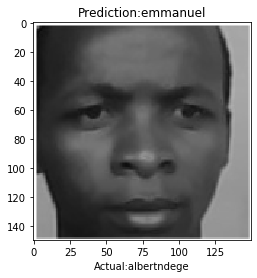

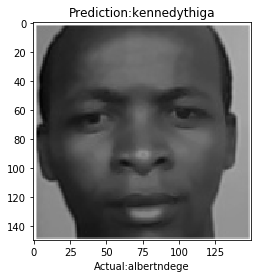

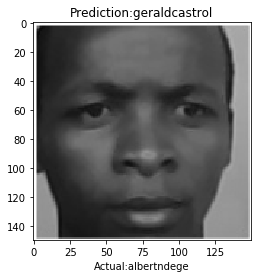

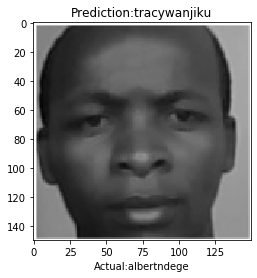

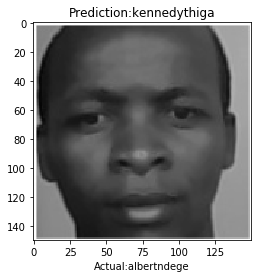

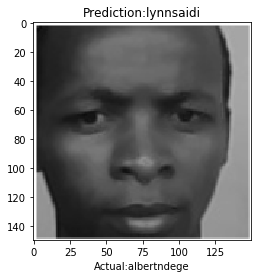

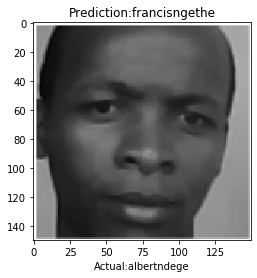

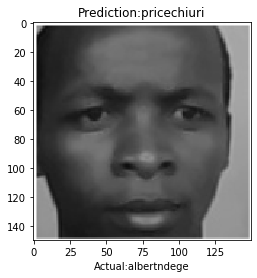

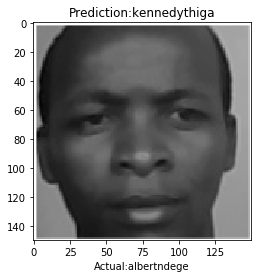

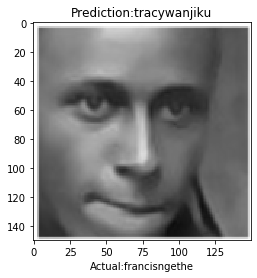

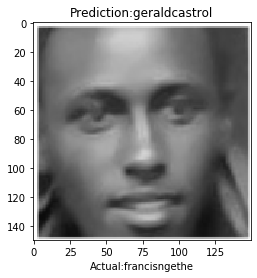

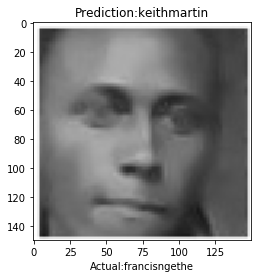

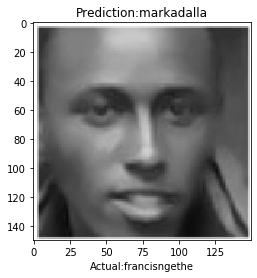

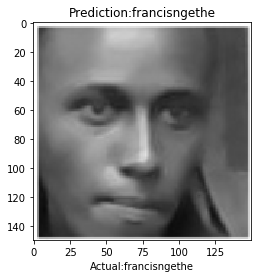

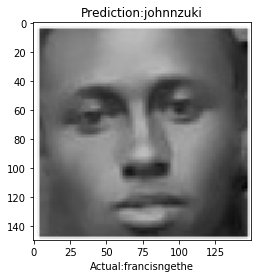

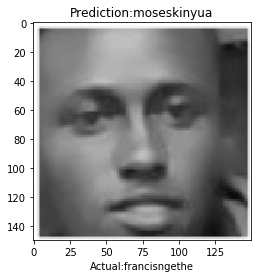

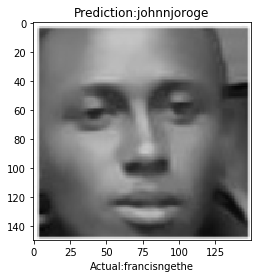

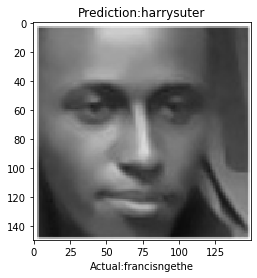

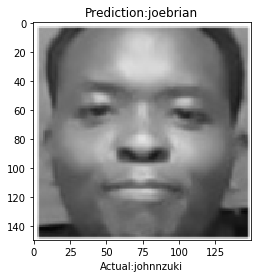

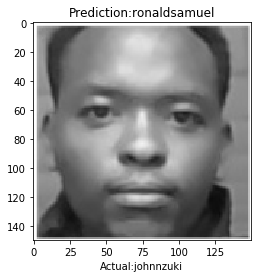

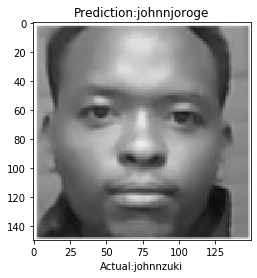

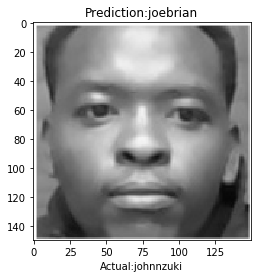

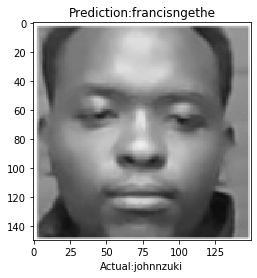

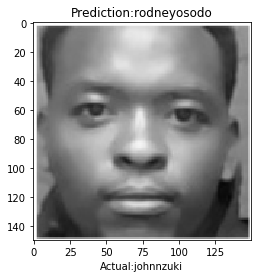

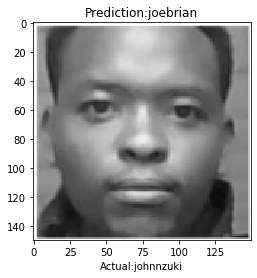

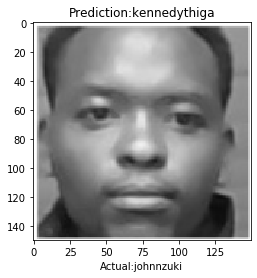

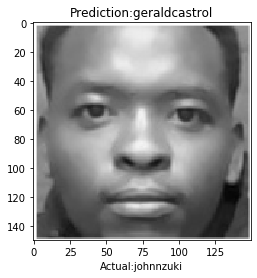

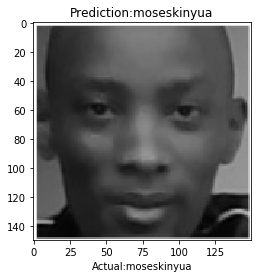

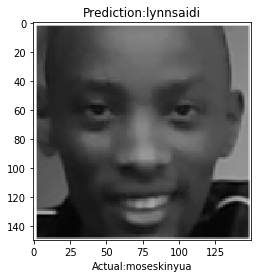

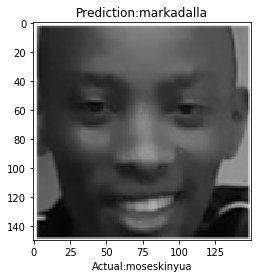

In [98]:
for i in range(30):
    plt.grid(False)
    plt.imshow(test_images[i], cmap = plt.cm.binary)
    plt.xlabel("Actual:" + CATEGORIES[(test_labels[i])])  

    #plt.xlabel("Actual:" + CATEGORIES[np.argmax(test_labels[i])]) 
    plt.title("Prediction:" + CATEGORIES[np.argmax(models_predictions[i])])  
    plt.show()

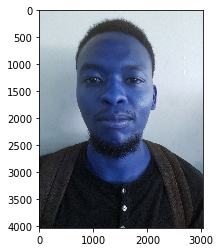

In [99]:
test_image = '/home/tech-iguana/Documents/facial_stuff/tf_facial_model/images/trainn/johnnzuki/'

img_path = os.path.join(test_image,'20200219_122821.jpg')
img = cv2.imread(img_path)  
plt.imshow(img)

In [102]:
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = new_model.predict(x)
#print('Predicted:', decode_predictions(preds, top=3)[0])
CATEGORIES[np.argmax(preds)]

'geraldcastrol'

### Model Evaluation.

In [80]:
predicted_classes = np.argmax(models_predictions, axis=1)

In [81]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [86]:
from sklearn import metrics


report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

                 precision    recall  f1-score   support

    albertndege       0.00      0.00      0.00         9
  ashleywangare       0.11      0.11      0.11         9
    elviswahome       0.00      0.00      0.00         9
       emmanuel       0.22      0.22      0.22         9
  francisngethe       0.11      0.11      0.11         9
  geraldcastrol       0.11      0.11      0.11         9
     harrysuter       0.11      0.11      0.11         9
         jameso       0.11      0.11      0.11         9
       joebrian       0.00      0.00      0.00         9
    johnnjoroge       0.11      0.11      0.11         9
      johnnzuki       0.11      0.11      0.11         9
    keithmartin       0.00      0.00      0.00         9
   kennedythiga       0.09      0.11      0.10         9
      lynnsaidi       0.00      0.00      0.00         9
     markadalla       0.00      0.00      0.00         9
    moseskinyua       0.00      0.00      0.00         9
patrickwainaina       0.11    

### Cross validation

In [91]:
from sklearn.model_selection import  cross_val_score

In [92]:
print(cross_val_score(new_model, training_data, test_data, cv = 3))

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7faeb81e7c90> does not.

### Confusion matrix

In [71]:
from sklearn.metrics import confusion_matrix


In [72]:
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)

In [73]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [74]:
cm_plot_labels = ['correctly classified','wrongly classified']

Confusion matrix, without normalization
[[0 1 0 0 1 1 0 0 0 0 0 0 2 0 1 2 0 0 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 2 0 0 1 0 1 0 1 0 2 0 0 0]
 [0 0 0 0 2 1 0 0 1 0 0 1 0 2 0 0 0 0 1 0 1 0]
 [1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0]
 [1 1 0 1 0 1 1 1 0 0 0 2 0 0 0 0 0 0 0 0 1 0]
 [1 1 0 2 0 0 0 1 1 0 0 0 0 1 2 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 2 0 1]
 [0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1]
 [1 1 0 0 2 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 1 1 1 0 1 2 1 0 0 1 0 0 0 1 0]
 [0 0 2 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1]
 [1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 2]
 [1 0 0 0 0 0 0 0 2 0 2 0 0 0 1 1 0 1 0 0 1 0]
 [0 0 0 1 0 1 1 0 0 1 1 0 3 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1]
 [0 0 1 0 0 1 2 1 1 0 2 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 2 1 1 0 0]
 [1 1 1 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0]
 [0 0 4 0 1 0 0 2 0 0 0 0 0 1 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 2 1]
 [0 0 0 0 0 0 0 0 2 

NameError: name 'itertools' is not defined

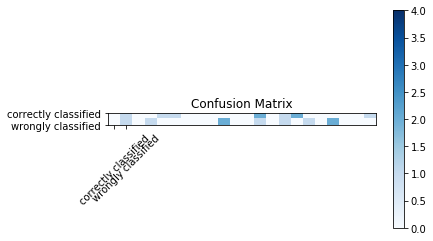

In [75]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')